# Notebook dedicated to construct the test dataset of solar Nue and 208Tl events

Convention to define the size of train and test data set: The last two files in the list of directories of .root files are for test

In [1]:
import uproot
import numpy as np
import pandas as pd
import random

import glob
import re
import os

import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

# Useful Functions

In [7]:
def magnitude(vector): 
    #Function to Compute the radial position of events
    x = vector[:,0]
    y = vector[:,1]
    z = vector[:,2]

    r = np.sqrt(x**2 + y**2 + z**2)
    r = r.astype(np.float32)
    return r

In [8]:
def random_unit_vector(seed=None):
    # Create a random generator with optional seed
    rng = np.random.default_rng(seed)
    # Generate 3 components from a normal distribution
    vec = rng.normal(size=3)
    # Normalize to unit length
    vec /= np.linalg.norm(vec)
    return vec

# Read Files: Get the file list with the full directories of .root files

In [9]:
main_dir = 'E:/Data/solars/mc/'
solarNue_fdir = 'solar_Nue/High Stat/solar_Nue*.root'
tl_208_fdir = '208tl/High Stat/tl208*.root'

solar_Nue_flist = glob.glob(main_dir + solarNue_fdir )[-2:] #Selected the elements in list of dir to be used for training
tl_208_flist = glob.glob(main_dir + tl_208_fdir)[-2:] #Selected the elements in list of dir to be used for training

In [10]:
solar_Nue_flist

['E:/Data/solars/mc/solar_Nue/High Stat\\solar_Nue_mc_analysis_8.root',
 'E:/Data/solars/mc/solar_Nue/High Stat\\solar_Nue_mc_analysis_9.root']

In [11]:
tl_208_flist

['E:/Data/solars/mc/208tl/High Stat\\tl208_mc_analysis_8.root',
 'E:/Data/solars/mc/208tl/High Stat\\tl208_mc_analysis_9.root']

# Analysis of .root files: Extract Observables of Interest

In [12]:
# ============ Data Cuts Settings ============
energy_inf_cut = 2.5
energy_sup_cut = 12

posr_cut = 5500

time_res_inf_cut = -5
time_res_sup_cut = 7

nhits_cut = 20 #Nhits cut to be applied after the time residual cuts

# Output files directory
out_file_dir = f'E:/Data/solars/mc/ML Data/Test/np_arrays/E_{energy_inf_cut}_{energy_sup_cut}_MeV_R_{posr_cut}_mm_Delta_{time_res_inf_cut}_{time_res_sup_cut}_ns/'
os.makedirs(out_file_dir, exist_ok=True)

## Solars Analysis

In [13]:
data_type_fname = 'solarNue'

# -------------------------------------------------------

for fi_dx, input_file_dir in enumerate(solar_Nue_flist):
    print(f'In file {input_file_dir}')
    
    #Load the Data:
    load_data = uproot.open(input_file_dir)
    
    #select the tree of event data and PMT info
    TTree_data_name = load_data.keys()[0]
    TTree_pmt_info_name = load_data.keys()[-1]
    
    event_data = load_data[TTree_data_name]
    pmt_data = load_data[TTree_pmt_info_name]
    
    #event info to be used:
    var_event_list = ['evtid', 'energy', 'position', 'mc_momentum',
                      'hit_pmtid', 'hit_residual' ]  #list the name of the varibles to be extracted and used for the solarnu analysis.
    
    #pmt info to be used
    var_pmt_list = ['pmt_id', 'pmt_pos_xyz', 'pmt_type']
    
    #Observables to save
    var_name_save_list = ['evtid', 'energy', 'posr', 'hit_residual']
    multi_cos_alpha = [] #create the empty list of the cos_alpha for the multiple PMTs record
    n_init_evs = []  # Initial Nº of Solar Nue MC events
    n_final_evs = [] # Initial Nº of Solar Nue MC events
    
    # Extract the variables with the name of the var_event_list in numpy.array from the .root file
    observables = {}
    
    # Load variables form the Event Info TTree Branch
    for var_name_i in var_event_list:
        observables[var_name_i] = np.array(event_data[var_name_i])
        
    # ============= Count the initial Nº of events =============
    evtid = observables['evtid']
    evIDi_unique = []  #Empty list to be filled with the unique (non-redundant) values of the initial evIDs. len(evIDi_unique) = Nº of events

    N_data = len(evtid)
    indices_to_delete = [] #Indiced to remove from the observable arrays due to nhits cut

    data_break_i = [0]  #array whose elements are the index from where an event start and end.
    #Loop to extract the indices where evtid breaks
    for i_dx in range(N_data - 1):
        if evtid[i_dx] != evtid[i_dx+1]:
            data_break_i.append(i_dx + 1)
            
    data_break_i.append(N_data - 1)

    N_terms = len(data_break_i)
    
    for i_dx in range(N_terms - 2):
        init_i = data_break_i[i_dx]
        final_i = data_break_i[i_dx + 1]
        evIDi_unique.append(evtid[init_i: final_i][0])

    N_evs = len(evIDi_unique)
    print(f'Nº of initial events: {N_evs}')
    n_init_evs.append(N_evs)
    # ===========================================================
    
    # Compute posr
    observables['posr'] = magnitude(observables['position'])
    
    # Load the PMT info TTree Branch
    try:
        #Try to extract the info from the PMT Branch
        for var_name_i in var_pmt_list:
            observables[var_name_i] = np.array(pmt_data[var_name_i])
            
    except uproot.KeyInFileError as e:
        #if the Branch doesnt exist, then use the PMT info from other file that we know contais the PMT info Branch
        load_data = uproot.open('E:/Data/solars/mc/solar_Nue/High Stat/solar_Nue_mc_analysis_0.root')
        pmt_data = load_data['pmt;1']
        for var_name_i in var_pmt_list:
            observables[var_name_i] = np.array(pmt_data[var_name_i])
    
    # Filtering of valid PMT id through PMT type
    pmt_type_condition = (observables['pmt_type'] == 1)
    pmt_id_valid = observables['pmt_id'][pmt_type_condition]
    
    # general cut conditions
    hit_pmt_id_condition = np.in1d(observables['hit_pmtid'], pmt_id_valid)
    energy_condition = (observables['energy'] >= energy_inf_cut) & (observables['energy'] <= energy_sup_cut)
    time_res_condition = (observables['hit_residual'] >= time_res_inf_cut) & (observables['hit_residual'] <= time_res_sup_cut)
    posr_condition = (observables['posr'] <= posr_cut)
    
    general_condition = hit_pmt_id_condition & energy_condition & time_res_condition & posr_condition
    
    # Apply the general cut conditions to observables
    for var_name_i in var_event_list:
        observables[var_name_i] = observables[var_name_i][general_condition]
    observables['posr'] = observables['posr'][general_condition]

    #print(f'selected energies form {input_file_dir}: {observables['energy']} with shape {observables['energy'].shape}')

# ======== Counts of final events ======
    print('performing nhits cuts after general selections')
    evtid = observables['evtid']
    evIDf_unique = []  #Empty list to be filled with the unique (non-redundant) values of the final evIDs. len(evIDf_unique) = Nº of final events
    N_data = len(evtid)
    indices_to_delete = [] #Indiced to remove from the observable arrays due to nhits cut

    data_break_i = [0]  #array whose elements are the index from where an event start and end.
    #Loop to extract the indices where evtid breaks
    for i_dx in range(N_data - 1):
        if evtid[i_dx] != evtid[i_dx+1]:
            data_break_i.append(i_dx + 1)
            
    data_break_i.append(N_data - 1)

    N_terms = len(data_break_i)

    for i_dx in range(N_terms - 2):
        init_i = data_break_i[i_dx]
        final_i = data_break_i[i_dx + 1]

        evIDf_unique.append(evtid[init_i: final_i][0]) #Count the Number of final events
            
    N_evs = len(evIDf_unique)
    print(f'Nº of final events: {N_evs}')
    n_final_evs.append(N_evs)

    # ====================================================================
    
    # Add to dictionary of observables the keys init evs and final evs
    observables['n_init_evs'] = n_init_evs
    observables['n_final_evs'] = n_final_evs
    
    # Save desired variables
    full_observable_save_list = var_name_save_list + ['n_init_evs', 'n_final_evs']
    
    print(f'saving observables {full_observable_save_list}')
    
    for var_name_i in  full_observable_save_list:
        np.save(out_file_dir + data_type_fname + '_' + var_name_i + f'_{fi_dx}.npy', observables[var_name_i])

    #cos_alpha computation
    #The cos_alpha computation must be done by parts using a split in the data.
    
    N_samples = len(observables['hit_residual'])

    print('Computing cos_alpha')
    
    for sample_idx in range(N_samples):
        
        sun_dir = observables['mc_momentum'][sample_idx]
        pmt_hit_id = observables['hit_pmtid'][sample_idx]
        pmt_hit_xyz = observables['pmt_pos_xyz'][pmt_hit_id]

        norm1 = np.linalg.norm(sun_dir)
        norm2 = np.linalg.norm(pmt_hit_xyz)
        
        sun_dir = sun_dir / norm1
        sun_dir = sun_dir.astype(np.float32)
        
        pmt_hit_xyz = pmt_hit_xyz / norm2
        pmt_hit_xyz = pmt_hit_xyz.astype(np.float32)
    
        dot_prod = np.dot(sun_dir, pmt_hit_xyz)
        cos_alpha = dot_prod
    
        multi_cos_alpha.append(cos_alpha)

    multi_cos_alpha = np.array(multi_cos_alpha)
    print('saving cos_alpha')
    # Guardar los cos(alpha)
    np.save(out_file_dir + data_type_fname + '_cos_alpha' + f'_{fi_dx}.npy', multi_cos_alpha)

print('Analysis Done!')

In file E:/Data/solars/mc/solar_Nue/High Stat\solar_Nue_mc_analysis_8.root
Nº of initial events: 78150
performing nhits cuts after general selections
Nº of final events: 27525
saving observables ['evtid', 'energy', 'posr', 'hit_residual', 'n_init_evs', 'n_final_evs']
Computing cos_alpha
saving cos_alpha
In file E:/Data/solars/mc/solar_Nue/High Stat\solar_Nue_mc_analysis_9.root
Nº of initial events: 77465
performing nhits cuts after general selections
Nº of final events: 27271
saving observables ['evtid', 'energy', 'posr', 'hit_residual', 'n_init_evs', 'n_final_evs']
Computing cos_alpha
saving cos_alpha
Analysis Done!


## 208Tl Analysis

In [14]:
data_type_fname = '208Tl'

# -------------------------------------------------------

for fi_dx, input_file_dir in enumerate(tl_208_flist):
    print(f'In file {input_file_dir}')
    
    #Load the Data:
    load_data = uproot.open(input_file_dir)  #ROOT File
    #sun_dir = np.load(out_file_dir + f'sun_dir_{fi_dx}.npy') #Solar direction from MC Solar Nue Data to replace 208Tl event
    #solar_evID = np.load(out_file_dir + f'solarNue_evtid_{fi_dx}.npy') #Solar evID to cut on 208Tl data due to direction replacement
    
    #select the tree of event data and PMT info
    TTree_data_name = load_data.keys()[0]
    TTree_pmt_info_name = load_data.keys()[-1]
    
    event_data = load_data[TTree_data_name]
    pmt_data = load_data[TTree_pmt_info_name]
    
    #event info to be used:
    var_event_list = ['evtid', 'energy', 'position', 'mc_momentum',
                      'hit_pmtid', 'hit_residual' ]  #list the name of the varibles to be extracted and used for the solarnu analysis.
    
    #pmt info to be used
    var_pmt_list = ['pmt_id', 'pmt_pos_xyz', 'pmt_type']
    
    #Observables to save
    var_name_save_list = ['evtid', 'energy', 'posr', 'hit_residual']
    multi_cos_alpha = [] #create the empty list of the cos_alpha for the multiple PMTs record
    n_init_evs = []  # Initial Nº of 208Tl  MC events
    n_final_evs = [] # Initial Nº of 208Tl MC events
    
    # Extract the variables with the name of the var_event_list in numpy.array from the .root file
    observables = {}
    
    # Load variables form the Event Info TTree Branch
    for var_name_i in var_event_list:
        observables[var_name_i] = np.array(event_data[var_name_i])

    # ============= Count the initial Nº of events =============
    evtid = observables['evtid']
    evIDi_unique = []  #Empty list to be filled with the unique (non-redundant) values of the initial evIDs. len(evIDi_unique) = Nº of events

    N_data = len(evtid)
    indices_to_delete = [] #Indiced to remove from the observable arrays due to nhits cut

    data_break_i = [0]  #array whose elements are the index from where an event start and end.
    #Loop to extract the indices where evtid breaks
    for i_dx in range(N_data - 1):
        if evtid[i_dx] != evtid[i_dx+1]:
            data_break_i.append(i_dx + 1)
            
    data_break_i.append(N_data - 1)

    N_terms = len(data_break_i)
    
    for i_dx in range(N_terms - 2):
        init_i = data_break_i[i_dx]
        final_i = data_break_i[i_dx + 1]
        evIDi_unique.append(evtid[init_i: final_i][0])

    N_evs = len(evIDi_unique)
    print(f'Nº of initial events: {N_evs}')
    n_init_evs.append(N_evs)
    # ===========================================================
    
    # posr Calculation
    observables['posr'] = magnitude(observables['position'])
    
    # Cargar variables del árbol de PMTs
    try:
        #Try to extract the info from the PMT Branch
        for var_name_i in var_pmt_list:
            observables[var_name_i] = np.array(pmt_data[var_name_i])
            
    except uproot.KeyInFileError as e:
        #if the Branch doesnt exist, then use the PMT info from other file that we know contais the PMT info Branch
        load_data = uproot.open('E:/Data/solars/mc/solar_Nue/High Stat/solar_Nue_mc_analysis_0.root')
        pmt_data = load_data['pmt;1']
        for var_name_i in var_pmt_list:
            observables[var_name_i] = np.array(pmt_data[var_name_i])
    
    # Filtering of valid PMT id through PMT type
    pmt_type_condition = (observables['pmt_type'] == 1)
    pmt_id_valid = observables['pmt_id'][pmt_type_condition]
    
    # general cut conditions
    hit_pmt_id_condition = np.in1d(observables['hit_pmtid'], pmt_id_valid)
    energy_condition = (observables['energy'] >= energy_inf_cut) & (observables['energy'] <= energy_sup_cut)
    time_res_condition = (observables['hit_residual'] >= time_res_inf_cut) & (observables['hit_residual'] <= time_res_sup_cut)
    posr_condition = (observables['posr'] <= posr_cut)
    
    general_condition = hit_pmt_id_condition & energy_condition & time_res_condition & posr_condition
    
    # Apply the general cut conditions to observables
    for var_name_i in var_event_list:
        observables[var_name_i] = observables[var_name_i][general_condition]
    observables['posr'] = observables['posr'][general_condition]

    print('Redefining 208Tl direction')
    #208Tl direction Redefinition with random rotations of vectors: ----------------------------------------------------------------
    
    # Verify where the data recorded during and event breaks
    tl_break_i = [0]
    tl208_evID = observables['evtid']

    tl_N_data = len(tl208_evID)
    for tl_i in range(tl_N_data - 1):
        if tl208_evID[tl_i] != tl208_evID[tl_i+1]:
            tl_break_i.append(tl_i+1) #append the index where data breaks

    #Redefine every repeated value direction with the new rotated direction
    print(f'True 208Tl momentum {observables['mc_momentum']}')
    N_breaks = len(tl_break_i)
    for i_dx in range(N_breaks - 1):
        random_vec = random_unit_vector(seed = 42)
        i_tl = tl_break_i[i_dx]
        f_tl = tl_break_i[i_dx + 1]
        observables['mc_momentum'][i_tl:f_tl] = random_vec
        #observables['mc_momentum'][i_tl:f_tl] = apply_random_rotation_per_vector([observables['mc_momentum'][i_tl:f_tl][0]], seed = 42, verbose = False)
    observables['mc_momentum'][tl_break_i[-1]:] = random_vec
    #observables['mc_momentum'][tl_break_i[-1]:] = apply_random_rotation_per_vector([observables['mc_momentum'][-1]], seed = 42, verbose = False)
    
    #208Tl direction Redefinition with the direction of solar Nue Mc: ----------------------------------------------------------------
    
    #Match the Nº of events on Tl208 with the solar Nue to correctly replace the 208Tl direction with the sun direction
    #1) Verify where the data recorded during and event breaks;
    #2) Evaluate for each event record the number of entries;
    #3) Evaluate if N_Nue < or > than N_208Tl, and cut depending on this;

    #print('evaluating where the indices Break')
    #1)
    #solar_break_i = [0] #List with the indices where the ev data breaks
    #tl_break_i = [0]
    #tl208_evID = observables['evtid']

    #solar_N_data = len(solar_evID)
    #for solar_i in range(solar_N_data - 1):
    #    if solar_evID[solar_i] != solar_evID[solar_i+1]:
    #        solar_break_i.append(solar_i+1) #append the index where data breaks
        
    #tl_N_data = len(tl208_evID)
    #for tl_i in range(tl_N_data - 1):
    #    if tl208_evID[tl_i] != tl208_evID[tl_i+1]:
    #        tl_break_i.append(tl_i+1) #append the index where data breaks

    #2) and 3)
    #N_solar_evs = len(solar_break_i)
    #N_tl_evs = len(tl_break_i)

    #print(f'N_solar_evs = {N_solar_evs}')
    #print(f'N_208Tl_evs = {N_tl_evs}')

    #if N_solar_evs > N_tl_evs:
    #    solar_break_i = solar_break_i[0:tl_N_data]        
    
    #if  N_tl_evs > N_solar_evs:
    #    tl_break_i = tl_break_i[0:N_solar_evs]

    #print(f'True 208Tl momentum {observables['mc_momentum']}')

    #N_breaks = len(tl_break_i)
    #for i_dx in range(N_breaks - 1):
    #    i_solar = solar_break_i[i_dx]
    #    f_solar = solar_break_i[i_dx + 1]
    #    i_tl = tl_break_i[i_dx]
    #    f_tl = tl_break_i[i_dx + 1]
    #    observables['mc_momentum'][i_tl:f_tl] = sun_dir[i_solar:f_solar][0]
    #observables['mc_momentum'][tl_break_i[-1]:-1] = sun_dir[-1]
    
    #print(f'new 208Tl momentum {observables['mc_momentum']}')
    print('208Tl direction redefined!')

    #print(f'selected energies form {input_file_dir}: {observables['energy']} with shape {observables['energy'].shape}')

    # ======== Counts of final events ======
    print('performing nhits cuts after general selection')
    evtid = observables['evtid']
    evIDf_unique = []  #Empty list to be filled with the unique (non-redundant) values of the final evIDs. len(evIDf_unique) = Nº of final events
    N_data = len(evtid)
    indices_to_delete = [] #Indiced to remove from the observable arrays due to nhits cut

    data_break_i = [0]  #array whose elements are the index from where an event start and end.
    #Loop to extract the indices where evtid breaks
    for i_dx in range(N_data - 1):
        if evtid[i_dx] != evtid[i_dx+1]:
            data_break_i.append(i_dx + 1)
            
    data_break_i.append(N_data - 1)

    N_terms = len(data_break_i)

    for i_dx in range(N_terms - 2):
        init_i = data_break_i[i_dx]
        final_i = data_break_i[i_dx + 1]
        
        evIDf_unique.append(evtid[init_i: final_i][0]) #Count the Number of final events
           
    N_evs = len(evIDf_unique)
    print(f'Nº of final events: {N_evs}')
    n_final_evs.append(N_evs)

    # ====================================================================
    
    #Add to dictionary of observables the keys init evs and final evs
    observables['n_init_evs'] = n_init_evs
    observables['n_final_evs'] = n_final_evs
    
    # Save desired variables
    full_observable_save_list = var_name_save_list + ['n_init_evs', 'n_final_evs']
    
    print(f'saving observables {full_observable_save_list}')
    
    for var_name_i in  full_observable_save_list:
        np.save(out_file_dir + data_type_fname + '_' + var_name_i + f'_{fi_dx}.npy', observables[var_name_i])

    #cos_alpha computation
    #The cos_alpha computation must be done by parts using a split in the data.
    
    N_samples = len(observables['hit_residual'])

    print('Computing cos_alpha')
    
    for sample_idx in range(N_samples):
        
        fake_dir = observables['mc_momentum'][sample_idx]
        pmt_hit_id = observables['hit_pmtid'][sample_idx]
        pmt_hit_xyz = observables['pmt_pos_xyz'][pmt_hit_id]

        norm1 = np.linalg.norm(fake_dir)
        norm2 = np.linalg.norm(pmt_hit_xyz)
        
        fake_dir = fake_dir / norm1
        sun_dir = sun_dir
        
        pmt_hit_xyz = pmt_hit_xyz / norm2
        pmt_hit_xyz = pmt_hit_xyz
    
        dot_prod = np.dot(fake_dir, pmt_hit_xyz)
        cos_alpha = dot_prod
    
        multi_cos_alpha.append(cos_alpha)

    multi_cos_alpha = np.array(multi_cos_alpha)
    print('saving cos_alpha')
    # Guardar los cos(alpha)
    np.save(out_file_dir + data_type_fname + '_cos_alpha' + f'_{fi_dx}.npy', multi_cos_alpha)

print('Analysis Done!')

In file E:/Data/solars/mc/208tl/High Stat\tl208_mc_analysis_8.root
Nº of initial events: 47183
Redefining 208Tl direction
True 208Tl momentum [[-0.19792032 -0.23424689  0.17514113]
 [-0.19792032 -0.23424689  0.17514113]
 [-0.19792032 -0.23424689  0.17514113]
 ...
 [-0.49488008 -0.28228498 -0.68482244]
 [-0.49488008 -0.28228498 -0.68482244]
 [-0.49488008 -0.28228498 -0.68482244]]
208Tl direction redefined!
performing nhits cuts after general selection
Nº of final events: 25904
saving observables ['evtid', 'energy', 'posr', 'hit_residual', 'n_init_evs', 'n_final_evs']
Computing cos_alpha
saving cos_alpha
In file E:/Data/solars/mc/208tl/High Stat\tl208_mc_analysis_9.root
Nº of initial events: 46536
Redefining 208Tl direction
True 208Tl momentum [[-0.2711021   0.54653656 -0.03945704]
 [-0.2711021   0.54653656 -0.03945704]
 [-0.2711021   0.54653656 -0.03945704]
 ...
 [-0.04861746  0.55329627 -0.61074632]
 [-0.04861746  0.55329627 -0.61074632]
 [-0.04861746  0.55329627 -0.61074632]]
208Tl di

# Load Numpy files

In [12]:
main_dir = f'E:/Data/solars/mc/ML Data/Test/np_arrays/E_{energy_inf_cut}_{energy_sup_cut}_MeV_R_{posr_cut}_mm_Delta_{time_res_inf_cut}_{time_res_sup_cut}_ns/'
solar_fpattern = 'SolarNue_'
tl208_fpattern = '208Tl_'

observable_name = ['evtid', 'energy', 'posr', 'cos_alpha', 'hit_residual']

solar_dict = {var_i: np.array([]) for var_i in observable_name}
tl208_dict = {var_i: np.array([]) for var_i in observable_name}

#Load each varibles within a loop of variables and fill the dictionaries
#Loop over var names
for var_i in observable_name:
    #create flist for the multiple var_i observables (exm: evID_0, evID_1, ...)
    solar_var_i_flist = glob.glob(main_dir + solar_fpattern + var_i + '*.npy')
    tl208_var_i_flist = glob.glob(main_dir + tl208_fpattern + var_i + '*.npy')

    #Loop over flist:
    for solar_file_i in solar_var_i_flist:
        load_solar_var_i = np.load(solar_file_i)
        solar_dict[var_i] = np.append(solar_dict[var_i], load_solar_var_i)

    for tl208_file_i in tl208_var_i_flist:
        load_208tl_var_i = np.load(tl208_file_i)
        tl208_dict[var_i] = np.append(tl208_dict[var_i], load_208tl_var_i)

## Remove Redundant Values

In [13]:
#Extract the redundant evID
solar_evID = solar_dict['evtid']
tl208_evID = tl208_dict['evtid']

redundant_observables_name = ['evtid', 'posr', 'energy'] #List of observables with redundant values to cut

# Empty lists which will contain the non-repeated values of the observables for singles events
solar_dict_ev = {var_i: [] for var_i in redundant_observables_name}
tl208_dict_ev = {var_i: [] for var_i in redundant_observables_name}

#evID index break list
solar_data_break_i = [0]  #array whose elements are the index from where an event start and end.
tl208_data_break_i = [0]

solar_N_data = len(solar_evID)
tl208_N_data = len(tl208_evID)

print('Looking for break index in solars evID')
for i_dx in range(solar_N_data - 1):
    if solar_evID[i_dx] != solar_evID[i_dx+1]:
        solar_data_break_i.append(i_dx+1)

print('Looking for break index in 208Tl evID')
for i_dx in range(tl208_N_data - 1):
    if tl208_evID[i_dx] != tl208_evID[i_dx+1]:
        tl208_data_break_i.append(i_dx+1)

#add the last index to complete the data_break_i list
solar_data_break_i.append(solar_N_data - 1)
tl208_data_break_i.append(tl208_N_data - 1)

N_solar_terms = len(solar_data_break_i)
N_tl208_terms = len(tl208_data_break_i)

#Start to save the non-redundant values and separate the time residuals and angles for each event
#Solar Loop
print(f'saving the non-redundant values for solars')
for i_dx in range(N_solar_terms - 1):
    init_i = solar_data_break_i[i_dx]
    final_i = solar_data_break_i[i_dx+1]
    
    for var_i in redundant_observables_name:
        non_redundant_var_i_value = solar_dict[var_i][init_i : final_i][0]
        solar_dict_ev[var_i].append(non_redundant_var_i_value)

#Transform to array
print('Transforming solars to np.array')
for var_i in redundant_observables_name:
    solar_dict_ev[var_i] = np.array(solar_dict_ev[var_i])

#Now append time residual and cos_alpha to solars
solar_dict_ev['cos_alpha'] = solar_dict['cos_alpha']
solar_dict_ev['hit_residual'] = solar_dict['hit_residual']

#208Tl Loop
print('Transforming 208Tl to np.array')
print(f'saving the non-redundant values for 208Tl')
for i_dx in range(N_tl208_terms - 1):
    init_i = tl208_data_break_i[i_dx]
    final_i = tl208_data_break_i[i_dx+1]

    for var_i in redundant_observables_name:
        non_redundant_var_i_value = tl208_dict[var_i][init_i : final_i][0]
        tl208_dict_ev[var_i].append(non_redundant_var_i_value)

#Transform to array
for var_i in redundant_observables_name:
    tl208_dict_ev[var_i] = np.array(tl208_dict_ev[var_i])

#Now append time residual and cos_alpha to 208Tl
tl208_dict_ev['cos_alpha'] = tl208_dict['cos_alpha']
tl208_dict_ev['hit_residual'] = tl208_dict['hit_residual']

Looking for break index in solars evID
Looking for break index in 208Tl evID
saving the non-redundant values for solars
Transforming solars to np.array
Transforming 208Tl to np.array
saving the non-redundant values for 208Tl


## NHits Cut: Select only events that verify nhits >= nhits_cut within the $\Delta$ window

In [14]:
# ========= nhits cut on Solar Data =========
solar_energy = solar_dict_ev['energy']
solar_posr = solar_dict_ev['posr']
solar_hit_residual = solar_dict_ev['hit_residual']
solar_cos_alpha = solar_dict_ev['cos_alpha']

solar_cos_alpha_ev = []  #cos(alpha) list to be filled with arrays, each one correspondign to an event record
solar_time_residual_ev = [] #time residual list to be filled with arrays, each one correspondign to an event record
solar_nhits = [] #List to be filled with the Nº of hits of each event within the  time residual window

#Loop to extract the Nº of hits per event using the evID break
for i_dx in range(N_solar_terms - 1):
    init_i = solar_data_break_i[i_dx]
    final_i = solar_data_break_i[i_dx+1]
    
    solar_cos_alpha_ev_i = solar_cos_alpha[init_i:final_i]
    solar_hit_residual_ev_i = solar_hit_residual[init_i:final_i]
    nhits_ev_i = len(solar_cos_alpha_ev_i)

    solar_cos_alpha_ev.append(solar_cos_alpha_ev_i)
    solar_time_residual_ev.append(solar_hit_residual_ev_i)
    solar_nhits.append(nhits_ev_i)
solar_nhits = np.array(solar_nhits)

#Selection of Events
nhits_condition = (solar_nhits >= nhits_cut)

solar_energy = solar_energy[nhits_condition]
solar_posr = solar_posr[nhits_condition]
solar_cos_alpha_ev = [arr for arr, cond in zip(solar_cos_alpha_ev, nhits_condition) if cond]
solar_time_residual_ev = [arr for arr, cond in zip(solar_time_residual_ev, nhits_condition) if cond]

# ========= nhits cut on 208Tl =========
tl208_energy = tl208_dict_ev['energy']
tl208_posr = tl208_dict_ev['posr']
tl208_hit_residual = tl208_dict_ev['hit_residual']
tl208_cos_alpha = tl208_dict_ev['cos_alpha']

tl208_cos_alpha_ev = []  #cos(alpha) list to be filled with arrays, each one correspondign to an event record
tl208_time_residual_ev = [] #time residual list to be filled with arrays, each one correspondign to an event record
tl208_nhits = [] #List to be filled with the Nº of hits of each event within the  time residual window

#Loop to extract the Nº of hits per event using the evID break
for i_dx in range(N_tl208_terms - 1):
    init_i = tl208_data_break_i[i_dx]
    final_i = tl208_data_break_i[i_dx+1]
    
    tl208_cos_alpha_ev_i = tl208_cos_alpha[init_i:final_i]
    tl208_hit_residual_ev_i = tl208_hit_residual[init_i:final_i]
    nhits_ev_i = len(tl208_cos_alpha_ev_i)

    tl208_cos_alpha_ev.append(tl208_cos_alpha_ev_i)
    tl208_time_residual_ev.append(tl208_hit_residual_ev_i)
    tl208_nhits.append(nhits_ev_i)
tl208_nhits = np.array(tl208_nhits)

#Selection of Events
nhits_condition = (tl208_nhits >= nhits_cut)

tl208_energy = tl208_energy[nhits_condition]
tl208_posr = tl208_posr[nhits_condition]
tl208_cos_alpha_ev = [arr for arr, cond in zip(tl208_cos_alpha_ev, nhits_condition) if cond]
tl208_time_residual_ev = [arr for arr, cond in zip(tl208_time_residual_ev, nhits_condition) if cond]

### Verify Plots

<Axes: ylabel='Count'>

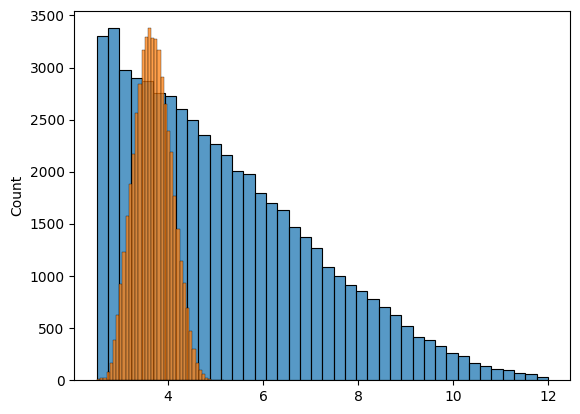

In [15]:
sn.histplot(solar_energy, bins = 40)
sn.histplot(tl208_energy, bins = 40)

<Axes: ylabel='Count'>

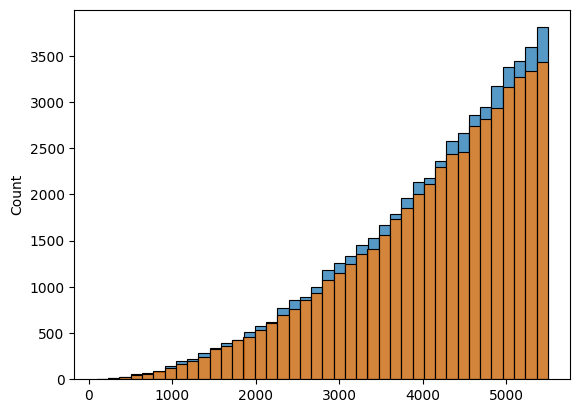

In [16]:
sn.histplot(solar_posr, bins = 40)
sn.histplot(tl208_posr, bins = 40)

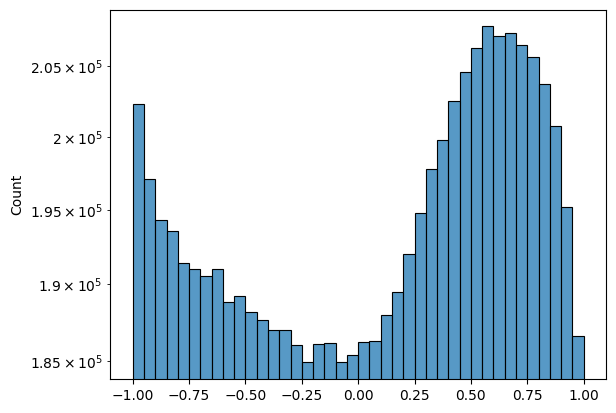

In [17]:
sn.histplot(solar_cos_alpha, bins = 40)
plt.yscale('log')

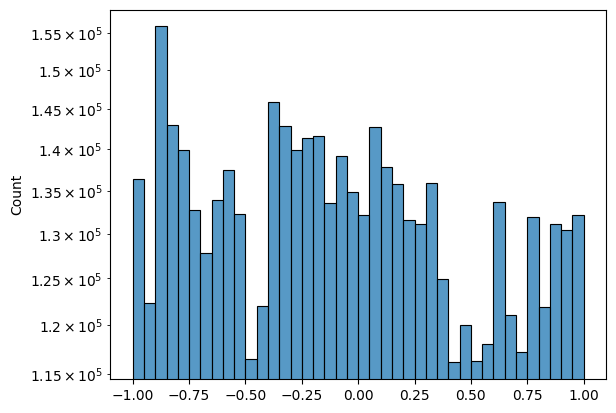

In [18]:
sn.histplot(tl208_cos_alpha, bins = 40)
plt.yscale('log')

<Axes: ylabel='Count'>

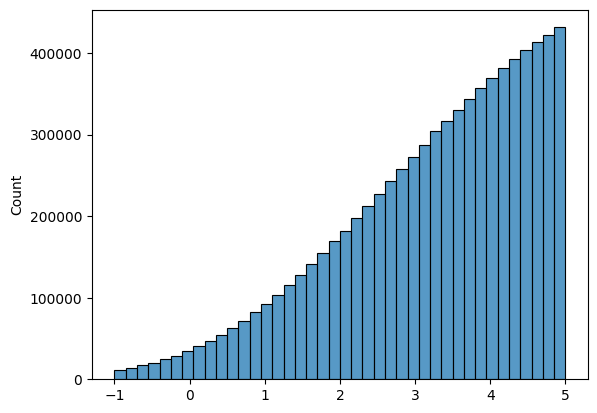

In [19]:
sn.histplot(solar_hit_residual, bins = 40)

<Axes: ylabel='Count'>

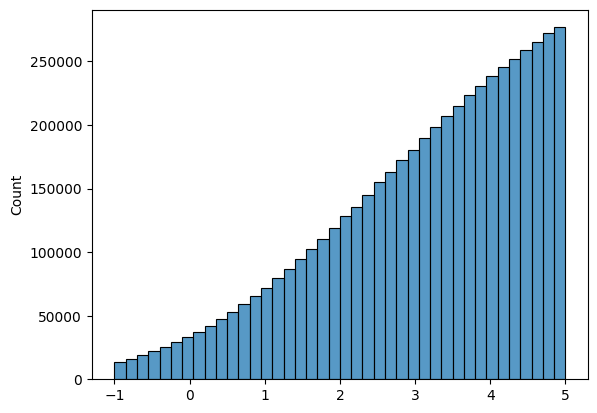

In [20]:
sn.histplot(tl208_hit_residual, bins = 40)

# Dataset Construction

## Solar Nue Dataset

### Features Construction: Pixels and Labels

In [21]:
image_dim = (10,10)
range_time = (time_res_inf_cut, time_res_sup_cut)
range_cos = (-1, 1)

H_flaten_nu = []  #flatten images of solar nu evs with shape (n_samples, bins x bins)
labels_nu = []  #save label of solar nu evs as [1,0]

N_evs = len(solar_cos_alpha_ev)

for i_dx in range(N_evs):

    solar_time_res_ev_i = solar_time_residual_ev[i_dx]
    solar_cos_ev_i = solar_cos_alpha_ev[i_dx]

    #raw histogram
    bins = image_dim[0]
    H_nu_ev, _, _ = np.histogram2d(x = solar_cos_ev_i, y = solar_time_res_ev_i, bins = [bins, bins], range = [range_cos, range_time])
    #normalization by NHits within slice of cos_alpha
    sum_hit_nu_ev = np.sum(H_nu_ev,axis=0)
    H_nu_ev_norm = H_nu_ev/sum_hit_nu_ev
    H_nu_ev_norm = np.nan_to_num(H_nu_ev_norm, nan = 0.0)

    H_flatten_ev = H_nu_ev_norm.ravel()
    H_flaten_nu.append(np.array(H_flatten_ev))
    labels_nu.append([1,0])
    
H_flaten_nu = np.array(H_flaten_nu)
labels_nu = np.array(labels_nu)

C:\Users\joanc\AppData\Local\Temp\ipykernel_412\1040089279.py:20: RuntimeWarning: invalid value encountered in divide
  H_nu_ev_norm = H_nu_ev/sum_hit_nu_ev


In [22]:
H_flaten_nu.shape

(54798, 100)

In [23]:
labels_nu.shape

(54798, 2)

### Verify the Images

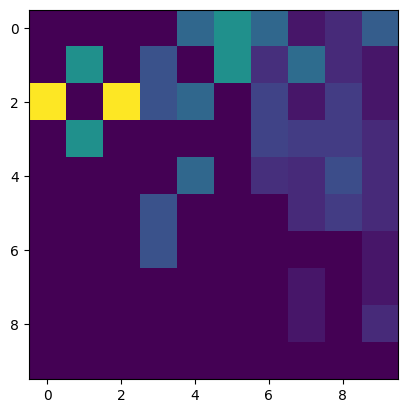

In [24]:
#High Stat
ev_i = 6
H_single_ev = H_flaten_nu[ev_i].reshape(bins, bins)
plt.imshow(H_single_ev)

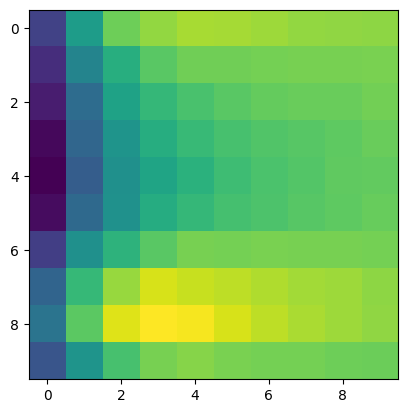

In [35]:
#High Stat
H_high_stat = np.sum(H_flaten_nu, axis = 0)
H_high_stat = H_high_stat.reshape(bins, bins)
plt.imshow(H_high_stat)

### Pandas Dataframe

In [26]:
df_solar_data = {}

N_pixel = bins*bins
for j in range(N_pixel):
    pixel_i = H_flaten_nu[:, j]
    df_solar_data['pixel_'+str(j)] = pixel_i

df_solar_data['energy (MeV)'] = solar_energy
df_solar_data['radius (mm)'] = solar_posr
df_solar_data['IsNu'] = labels_nu[:,0]
df_solar_data['IsTl'] = labels_nu[:,1]

df_solar_data = pd.DataFrame(df_solar_data)

In [27]:
df_solar_data

pixel_0  pixel_1   pixel_2  pixel_3   pixel_4   pixel_5   pixel_6  \
0          0.0     0.00  0.000000   0.0000  0.000000  0.000000  0.000000   
1          0.0     0.50  0.125000   0.2000  0.150000  0.500000  0.400000   
2          0.0     0.00  0.142857   0.0000  0.000000  0.045455  0.074074   
3          0.0     0.00  0.000000   0.0000  0.000000  0.000000  0.035714   
4          0.0     0.00  0.000000   0.0000  0.666667  0.000000  0.600000   
...        ...      ...       ...      ...       ...       ...       ...   
54793      0.0     0.00  0.000000   0.0000  0.000000  0.000000  0.000000   
54794      0.0     0.00  0.000000   1.0000  0.600000  0.571429  0.285714   
54795      0.0     0.00  0.000000   0.0000  0.000000  0.000000  0.000000   
54796      1.0     0.25  0.000000   0.0625  0.000000  0.068966  0.150000   
54797      0.0     0.00  1.000000   0.0000  0.200000  0.090909  0.428571   

        pixel_7   pixel_8   pixel_9  ...  pixel_94  pixel_95  pixel_96  \
0      0.000000  0.100000  0.100000  ...  0.000000  0.000000  0.200000   
1      0.137931  0.218750  0.230769  ...  0.000000  0.000000  0.000000   
2      0.040000  0.054054  0.064516  ...  0.000000  0.000000  0.000000   
3      0.050000  0.022222  0.025000  ...  0.066667  0.058824  0.071429   
4      0.190476  0.333333  0.181818  ...  0.000000  0.000000  0.000000   
...         ...       ...       ...  ...       ...       ...       ...   
54793  0.133333  0.000000  0.043478  ...  0.000000  0.000000  0.000000   
54794  0.285714  0.285714  0.107143  ...  0.000000  0.000000  0.000000   
54795  0.000000  0.033333  0.035714  ...  0.000000  0.076923  0.000000   
54796  0.095238  0.062500  0.054545  ...  0.000000  0.000000  0.000000   
54797  0.285714  0.076923  0.217391  ...  0.000000  0.000000  0.000000   

       pixel_97  pixel_98  pixel_99  energy (MeV)  radius (mm)  IsNu  IsTl  
0      0.100000  0.000000  0.100000      3.255294  1987.190552     1     0  
1      0.000000  0.000000  0.038462      4.910982  4580.352051     1     0  
2      0.000000  0.000000  0.000000      4.644320  5410.730469     1     0  
3      0.025000  0.088889  0.100000      7.901709  5215.486328     1     0  
4      0.047619  0.000000  0.090909      3.773207  2873.001221     1     0  
...         ...       ...       ...           ...          ...   ...   ...  
54793  0.066667  0.066667  0.000000      3.139037  4057.926270     1     0  
54794  0.095238  0.000000  0.000000      6.083028  2273.144287     1     0  
54795  0.076923  0.266667  0.071429      5.330648  3446.552490     1     0  
54796  0.000000  0.000000  0.018182      8.313311  4473.042969     1     0  
54797  0.000000  0.000000  0.000000      2.883846  4273.650879     1     0  

[54798 rows x 104 columns]

## 208Tl Dataset

### Features Construction: Pixels and Labels

In [29]:
image_dim = (10,10)
range_time = (time_res_inf_cut, time_res_sup_cut)
range_cos = (-1, 1)

H_flaten_tl = []  #flatten images of 208Tl nu evs with shape (n_samples, bins x bins)
labels_tl = []  #save label of solar nu evs as [0,1]

N_evs = len(tl208_cos_alpha_ev)

for i_dx in range(N_evs):

    tl208_time_res_ev_i = tl208_time_residual_ev[i_dx]
    tl208_cos_ev_i =  tl208_cos_alpha_ev[i_dx]

    #raw histogram
    bins = image_dim[0]
    H_tl_ev, _, _ = np.histogram2d(x = tl208_cos_ev_i, y =  tl208_time_res_ev_i, bins = [bins, bins], range = [range_cos, range_time])
    #normalization by NHits within slice of cos_alpha
    sum_hit_tl_ev = np.sum(H_tl_ev,axis=0)
    H_tl_ev_norm = H_tl_ev/sum_hit_tl_ev
    H_tl_ev_norm = np.nan_to_num(H_tl_ev_norm, nan = 0.0)

    H_flatten_ev = H_tl_ev_norm.ravel()
    H_flaten_tl.append(np.array(H_flatten_ev))
    labels_tl.append([0, 1])
    
H_flaten_tl = np.array(H_flaten_tl)
labels_tl = np.array(labels_tl)

C:\Users\joanc\AppData\Local\Temp\ipykernel_412\4015640549.py:20: RuntimeWarning: invalid value encountered in divide
  H_tl_ev_norm = H_tl_ev/sum_hit_tl_ev


In [30]:
H_flaten_tl.shape

(51337, 100)

In [31]:
labels_tl.shape

(51337, 2)

### Verify the Images

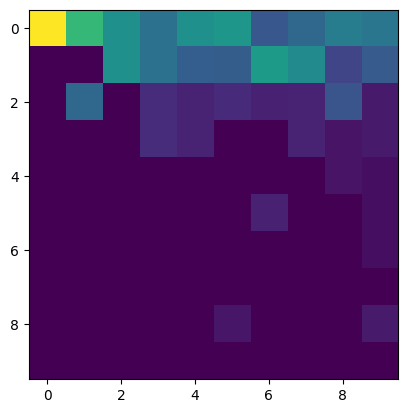

In [32]:
#High Stat
ev_i = 10
H_single_ev = H_flaten_tl[ev_i].reshape(bins, bins)
plt.imshow(H_single_ev)

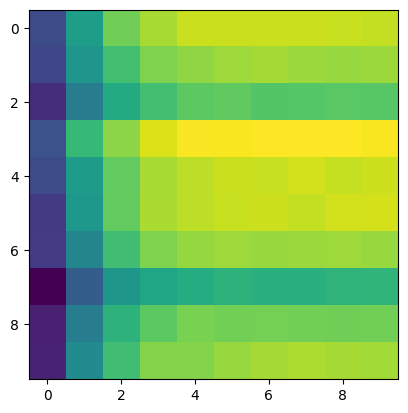

In [37]:
#High Stat
H_high_stat = np.sum(H_flaten_tl, axis = 0)
H_high_stat = H_high_stat.reshape(bins, bins)
plt.imshow(H_high_stat)

### Pandas Dataframe

In [38]:
df_tl208_data = {}

N_pixel = bins*bins
for j in range(N_pixel):
    pixel_i = H_flaten_tl[:, j]
    df_tl208_data['pixel_'+str(j)] = pixel_i

df_tl208_data['energy (MeV)'] = tl208_energy
df_tl208_data['radius (mm)'] = tl208_posr
df_tl208_data['IsNu'] = labels_tl[:,0]
df_tl208_data['IsTl'] = labels_tl[:,1]

df_tl208_data = pd.DataFrame(df_tl208_data)

In [39]:
df_tl208_data

pixel_0  pixel_1   pixel_2   pixel_3   pixel_4   pixel_5   pixel_6  \
0          1.0      0.0  0.400000  0.555556  0.000000  0.500000  0.176471   
1          0.0      1.0  0.000000  0.000000  0.400000  0.111111  0.285714   
2          0.0      0.0  0.000000  0.000000  0.500000  0.000000  0.111111   
3          0.0      0.0  0.000000  0.000000  0.000000  0.000000  0.333333   
4          0.0      0.0  0.250000  0.200000  0.000000  0.272727  0.250000   
...        ...      ...       ...       ...       ...       ...       ...   
51332      0.0      0.5  0.571429  0.777778  0.545455  0.846154  0.461538   
51333      0.0      0.0  0.000000  0.000000  0.000000  0.100000  0.000000   
51334      0.0      0.0  0.250000  0.000000  0.153846  0.000000  0.071429   
51335      0.0      0.0  0.000000  0.000000  0.285714  0.100000  0.000000   
51336      0.0      0.0  0.200000  0.600000  0.250000  0.375000  0.333333   

        pixel_7   pixel_8   pixel_9  ...  pixel_94  pixel_95  pixel_96  \
0      0.375000  0.100000  0.214286  ...  0.000000  0.000000  0.000000   
1      0.200000  0.142857  0.142857  ...  0.000000  0.000000  0.142857   
2      0.000000  0.428571  0.090909  ...  0.000000  0.000000  0.222222   
3      0.400000  0.148148  0.272727  ...  0.000000  0.000000  0.066667   
4      0.000000  0.043478  0.095238  ...  0.000000  0.090909  0.000000   
...         ...       ...       ...  ...       ...       ...       ...   
51332  0.294118  0.545455  0.375000  ...  0.000000  0.000000  0.000000   
51333  0.000000  0.000000  0.000000  ...  0.153846  0.100000  0.000000   
51334  0.000000  0.142857  0.034483  ...  0.000000  0.000000  0.000000   
51335  0.000000  0.125000  0.076923  ...  0.000000  0.000000  0.000000   
51336  0.142857  0.200000  0.111111  ...  0.000000  0.000000  0.000000   

       pixel_97  pixel_98  pixel_99  energy (MeV)  radius (mm)  IsNu  IsTl  
0      0.000000  0.000000  0.000000      3.149020  4387.667969     0     1  
1      0.066667  0.000000  0.000000      4.320164  2764.875977     0     1  
2      0.333333  0.142857  0.000000      3.423914   964.343750     0     1  
3      0.000000  0.037037  0.000000      3.833767  2697.529785     0     1  
4      0.000000  0.000000  0.095238      3.518195  3802.082764     0     1  
...         ...       ...       ...           ...          ...   ...   ...  
51332  0.000000  0.000000  0.000000      2.916830  5193.389160     0     1  
51333  0.086957  0.062500  0.173913      3.087799  4563.249512     0     1  
51334  0.047619  0.000000  0.034483      3.976594  4155.316895     0     1  
51335  0.000000  0.000000  0.076923      4.255462  3443.718994     0     1  
51336  0.000000  0.000000  0.000000      3.278950  4014.534668     0     1  

[51337 rows x 104 columns]

## Unify Solar_Nue and 208Tl Datasets

In [41]:
save = True
save_dir = 'E:/Data/solars/mc/ML Data/Test/pd_dataframe/'
fname = f'df_Dim_{image_dim[0]}_E_{energy_inf_cut}_{energy_sup_cut}_MeV_R_{posr_cut}_mm_Delta_{time_res_inf_cut}_{time_res_sup_cut}_ns.csv'

df = pd.concat([df_solar_data, df_tl208_data], ignore_index=True)

if save:
    df.to_csv(save_dir + fname, index=False)
    
df

pixel_0  pixel_1   pixel_2   pixel_3   pixel_4   pixel_5   pixel_6  \
0           0.0      0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
1           0.0      0.5  0.125000  0.200000  0.150000  0.500000  0.400000   
2           0.0      0.0  0.142857  0.000000  0.000000  0.045455  0.074074   
3           0.0      0.0  0.000000  0.000000  0.000000  0.000000  0.035714   
4           0.0      0.0  0.000000  0.000000  0.666667  0.000000  0.600000   
...         ...      ...       ...       ...       ...       ...       ...   
106130      0.0      0.5  0.571429  0.777778  0.545455  0.846154  0.461538   
106131      0.0      0.0  0.000000  0.000000  0.000000  0.100000  0.000000   
106132      0.0      0.0  0.250000  0.000000  0.153846  0.000000  0.071429   
106133      0.0      0.0  0.000000  0.000000  0.285714  0.100000  0.000000   
106134      0.0      0.0  0.200000  0.600000  0.250000  0.375000  0.333333   

         pixel_7   pixel_8   pixel_9  ...  pixel_94  pixel_95  pixel_96  \
0       0.000000  0.100000  0.100000  ...  0.000000  0.000000  0.200000   
1       0.137931  0.218750  0.230769  ...  0.000000  0.000000  0.000000   
2       0.040000  0.054054  0.064516  ...  0.000000  0.000000  0.000000   
3       0.050000  0.022222  0.025000  ...  0.066667  0.058824  0.071429   
4       0.190476  0.333333  0.181818  ...  0.000000  0.000000  0.000000   
...          ...       ...       ...  ...       ...       ...       ...   
106130  0.294118  0.545455  0.375000  ...  0.000000  0.000000  0.000000   
106131  0.000000  0.000000  0.000000  ...  0.153846  0.100000  0.000000   
106132  0.000000  0.142857  0.034483  ...  0.000000  0.000000  0.000000   
106133  0.000000  0.125000  0.076923  ...  0.000000  0.000000  0.000000   
106134  0.142857  0.200000  0.111111  ...  0.000000  0.000000  0.000000   

        pixel_97  pixel_98  pixel_99  energy (MeV)  radius (mm)  IsNu  IsTl  
0       0.100000  0.000000  0.100000      3.255294  1987.190552     1     0  
1       0.000000  0.000000  0.038462      4.910982  4580.352051     1     0  
2       0.000000  0.000000  0.000000      4.644320  5410.730469     1     0  
3       0.025000  0.088889  0.100000      7.901709  5215.486328     1     0  
4       0.047619  0.000000  0.090909      3.773207  2873.001221     1     0  
...          ...       ...       ...           ...          ...   ...   ...  
106130  0.000000  0.000000  0.000000      2.916830  5193.389160     0     1  
106131  0.086957  0.062500  0.173913      3.087799  4563.249512     0     1  
106132  0.047619  0.000000  0.034483      3.976594  4155.316895     0     1  
106133  0.000000  0.000000  0.076923      4.255462  3443.718994     0     1  
106134  0.000000  0.000000  0.000000      3.278950  4014.534668     0     1  

[106135 rows x 104 columns]